## Running the model with 2048 tokens, no text prompt

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Environment variable to improve memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Tokenizer and Model Initialization
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2)
model.gradient_checkpointing_enable()  # Enable gradient checkpointing
model.config.attention_window = [256] * len(model.config.attention_window)  # Reduce attention window to address outofmemory issues
model = model.to("cuda")  # Make sure model runs on GPU

# Custom Dataset Class
class ScriptDataset(Dataset):
    def __init__(self, scripts, labels, tokenizer, max_length=2048): #reduced to 2048 to address outofmemory issues
        self.scripts = scripts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.scripts)

    def __getitem__(self, idx):
        text = self.scripts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# DataLoader Preparation Function
def prepare_dataloader(data, tokenizer, max_length, batch_size):
    dataset = ScriptDataset(
        scripts=data["script"].tolist(),
        labels=data["passed_bechdel"].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load Datasets
train_data = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_data = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_data = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Create DataLoaders
train_loader = prepare_dataloader(train_data, tokenizer, max_length=2048, batch_size=1)
val_loader = prepare_dataloader(val_data, tokenizer, max_length=2048, batch_size=1)
test_loader = prepare_dataloader(test_data, tokenizer, max_length=2048, batch_size=1)

# Optimizer, Loss, and Scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()  # Mixed precision scaler
gradient_accumulation_steps = 4  # Accumulate gradients over 4 steps

# Training Loop
def train(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        with autocast():  # Enable mixed precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss = loss / gradient_accumulation_steps  # Scale loss for accumulation

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        # Periodically clear CUDA cache to manage memory
        if step % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Evaluation Loop
def evaluate(model, dataloader):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            with autocast():  # Mixed precision during evaluation
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, f1

# Main Training Loop
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy, val_f1 = evaluate(model, val_loader)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}")

# Evaluate on Test Data
test_loss, test_accuracy, test_f1 = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_5705/3782884818.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision scaler


Epoch 1/3


/tmp/ipykernel_5705/3782884818.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
Initializing global attention on CLS token...
/tmp/ipykernel_5705/3782884818.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision during evaluation


Train Loss: 0.7058, Train Accuracy: 0.4979
Validation Loss: 0.6932, Validation Accuracy: 0.5028, Validation F1: 0.6692
Epoch 2/3


/tmp/ipykernel_5705/3782884818.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipykernel_5705/3782884818.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision during evaluation


Train Loss: 0.6989, Train Accuracy: 0.4993
Validation Loss: 0.7021, Validation Accuracy: 0.5028, Validation F1: 0.6692
Epoch 3/3


/tmp/ipykernel_5705/3782884818.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipykernel_5705/3782884818.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision during evaluation


Train Loss: 0.6980, Train Accuracy: 0.5021
Validation Loss: 0.6941, Validation Accuracy: 0.4972, Validation F1: 0.0000


/tmp/ipykernel_5705/3782884818.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision during evaluation


Test Loss: 0.6943, Test Accuracy: 0.4944, Test F1: 0.0000


## Running the model with 3072 tokens and a text prompt explaining the Bechdel test
### run time ≈ 80 min

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Initializing global attention on CLS token...


Train Loss: 0.7024, Train Accuracy: 0.4944

Validation Metrics:
Accuracy: 0.4972
F1 Score: 0.0000
ROC-AUC: 0.5000
Confusion Matrix:
[[88  0]
 [89  0]]


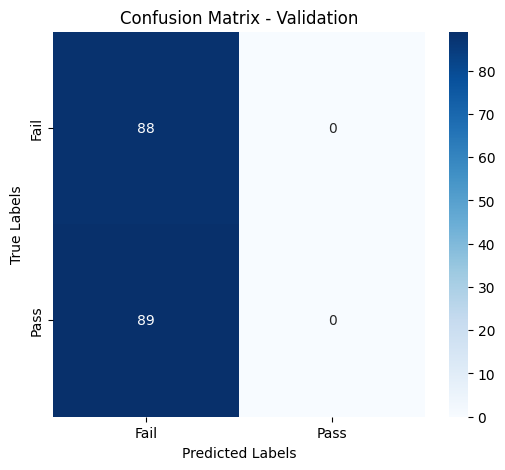

Validation Loss: 0.7006, Validation Accuracy: 0.4972, Validation F1: 0.0000, Validation ROC-AUC: 0.5000
Epoch 2/3
Train Loss: 0.7021, Train Accuracy: 0.4972

Validation Metrics:
Accuracy: 0.4972
F1 Score: 0.0000
ROC-AUC: 0.5350
Confusion Matrix:
[[88  0]
 [89  0]]


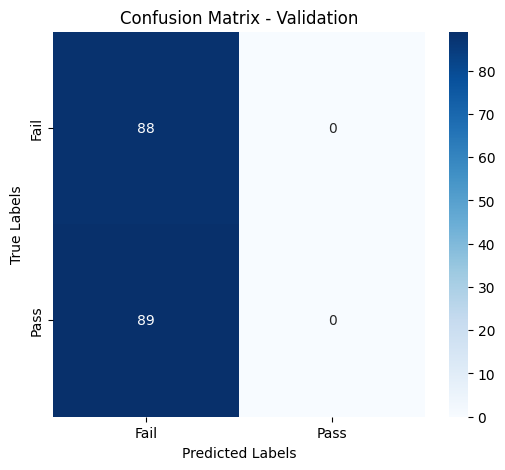

Validation Loss: 0.6938, Validation Accuracy: 0.4972, Validation F1: 0.0000, Validation ROC-AUC: 0.5350
Epoch 3/3
Train Loss: 0.6997, Train Accuracy: 0.4817

Validation Metrics:
Accuracy: 0.5028
F1 Score: 0.6692
ROC-AUC: 0.5000
Confusion Matrix:
[[ 0 88]
 [ 0 89]]


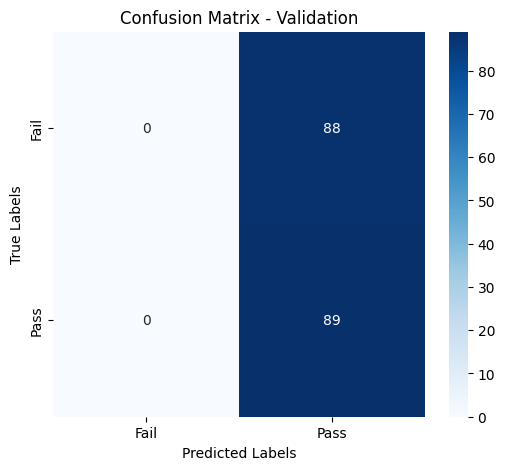

Validation Loss: 0.6936, Validation Accuracy: 0.5028, Validation F1: 0.6692, Validation ROC-AUC: 0.5000

Test Metrics:
Accuracy: 0.5056
F1 Score: 0.6716
ROC-AUC: 0.5000
Confusion Matrix:
[[ 0 88]
 [ 0 90]]


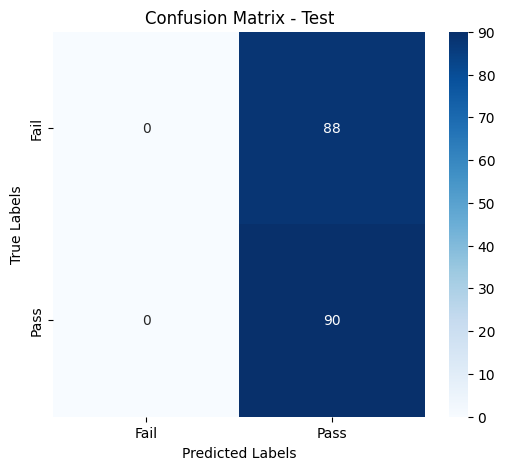

Test Loss: 0.6934, Test Accuracy: 0.5056, Test F1: 0.6716, Test ROC-AUC: 0.5000


In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Environment variable for memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Tokenizer and Model Initialization
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2)
model.gradient_checkpointing_enable()
model.config.attention_window = [256] * len(model.config.attention_window)
model = torch.nn.DataParallel(model).to("cuda")

# Dataset with Optional Instruction Prompt
class ScriptDataset(Dataset):
    def __init__(self, scripts, labels, tokenizer, max_length=3072, use_prompt=False):
        self.scripts = scripts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_prompt = use_prompt
        self.prompt = (
            "Does the following manuscript pass the Bechdel test or not? "
            "A movie passes the Bechdel test if it fulfills three requirements: "
            "1) There are at least two named female characters, 2) They have a conversation, "
            "3) About something other than a man. Manuscript: "
        )

    def __len__(self):
        return len(self.scripts)

    def __getitem__(self, idx):
        text = self.prompt + self.scripts[idx] if self.use_prompt else self.scripts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# DataLoader Preparation
def prepare_dataloader(data, tokenizer, max_length, batch_size, use_prompt=False):
    dataset = ScriptDataset(
        scripts=data["script"].tolist(),
        labels=data["passed_bechdel"].tolist(),
        tokenizer=tokenizer,
        max_length=max_length,
        use_prompt=use_prompt
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load datasets
train_data = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_data = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_data = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Create DataLoaders
train_loader = prepare_dataloader(train_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
val_loader = prepare_dataloader(val_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
test_loader = prepare_dataloader(test_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)

# Optimizer, Loss, and Scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()
gradient_accumulation_steps = 4

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title, dataset_name):
    """
    Plots a confusion matrix using Seaborn heatmap.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fail", "Pass"], yticklabels=["Fail", "Pass"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"{title} - {dataset_name}")
    plt.show()

# Training Loop
def train(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        with autocast("cuda"):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss = loss / gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        if step % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Evaluation Loop
def evaluate(model, dataloader, dataset_name):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            with autocast("cuda"):
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plot_confusion_matrix(conf_matrix, "Confusion Matrix", dataset_name)

    return total_loss / len(dataloader), accuracy, f1, roc_auc

# Main Training Loop
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train(model, train_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy, val_f1, val_roc_auc = evaluate(model, val_loader, "Validation")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}, Validation ROC-AUC: {val_roc_auc:.4f}")

# Evaluate on Test Data
test_loss, test_accuracy, test_f1, test_roc_auc = evaluate(model, test_loader, "Test")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Initializing global attention on CLS token...


Train Loss: 0.7092, Train Accuracy: 0.4873

Validation Metrics:
Accuracy: 0.5028
F1 Score: 0.6692
ROC-AUC: 0.5000
Confusion Matrix:
[[ 0 88]
 [ 0 89]]


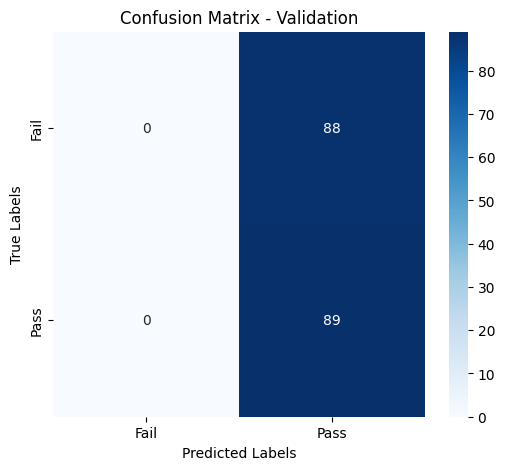

Validation Loss: 0.6951, Validation Accuracy: 0.5028, Validation F1: 0.6692, Validation ROC-AUC: 0.5000
Epoch 2/3
Train Loss: 0.7013, Train Accuracy: 0.4584

Validation Metrics:
Accuracy: 0.5028
F1 Score: 0.6692
ROC-AUC: 0.5000
Confusion Matrix:
[[ 0 88]
 [ 0 89]]


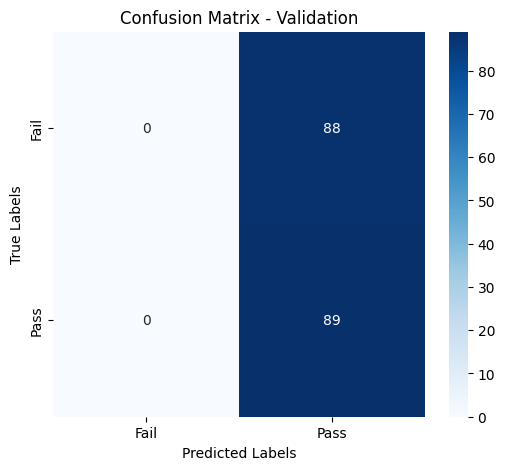

Validation Loss: 0.6959, Validation Accuracy: 0.5028, Validation F1: 0.6692, Validation ROC-AUC: 0.5000
Epoch 3/3
Train Loss: 0.6972, Train Accuracy: 0.5141

Validation Metrics:
Accuracy: 0.5028
F1 Score: 0.6692
ROC-AUC: 0.5000
Confusion Matrix:
[[ 0 88]
 [ 0 89]]


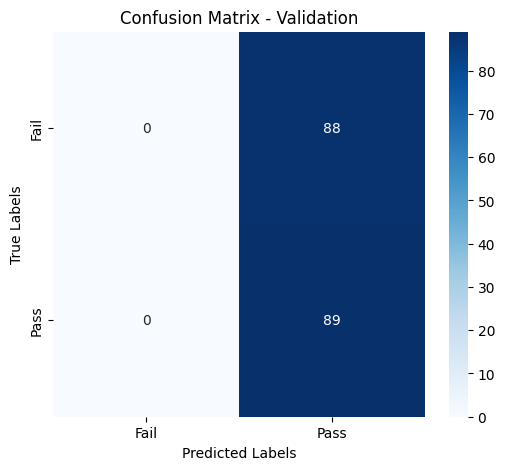

Validation Loss: 0.6954, Validation Accuracy: 0.5028, Validation F1: 0.6692, Validation ROC-AUC: 0.5000

Test Metrics:
Accuracy: 0.5056
F1 Score: 0.6716
ROC-AUC: 0.5000
Confusion Matrix:
[[ 0 88]
 [ 0 90]]


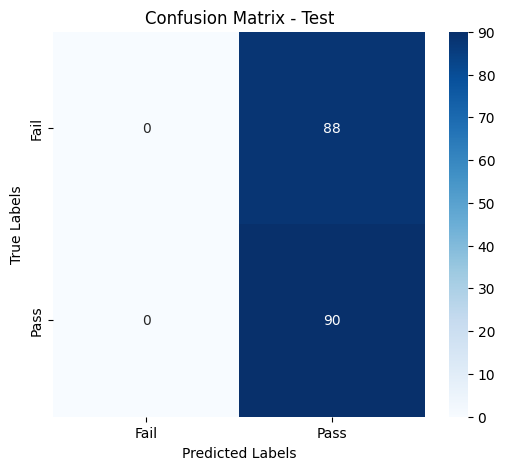

Test Loss: 0.6950, Test Accuracy: 0.5056, Test F1: 0.6716, Test ROC-AUC: 0.5000


In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Environment variable for memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Tokenizer and Model Initialization
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2)
model.gradient_checkpointing_enable()
model.config.attention_window = [256] * len(model.config.attention_window)
model = torch.nn.DataParallel(model).to("cuda")

# Dataset with Optional Instruction Prompt
class ScriptDataset(Dataset):
    def __init__(self, scripts, labels, tokenizer, max_length=3072, use_prompt=False):
        self.scripts = scripts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_prompt = use_prompt
        self.prompt = (
            "Does the following manuscript pass the Bechdel test or not? "
            "A movie passes the Bechdel test if it fulfills three requirements: "
            "1) There are at least two named female characters, 2) They have a conversation, "
            "3) About something other than a man. Manuscript: "
        )

    def __len__(self):
        return len(self.scripts)

    def __getitem__(self, idx):
        text = self.prompt + self.scripts[idx] if self.use_prompt else self.scripts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# DataLoader Preparation
def prepare_dataloader(data, tokenizer, max_length, batch_size, use_prompt=False):
    dataset = ScriptDataset(
        scripts=data["script"].tolist(),
        labels=data["passed_bechdel"].tolist(),
        tokenizer=tokenizer,
        max_length=max_length,
        use_prompt=use_prompt
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load datasets
train_data = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_data = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_data = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Create DataLoaders
train_loader = prepare_dataloader(train_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
val_loader = prepare_dataloader(val_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
test_loader = prepare_dataloader(test_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)

# Optimizer, Loss, and Scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01) #lowering weight decay to address regularization issues
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()
gradient_accumulation_steps = 4

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title, dataset_name):
    """
    Plots a confusion matrix using Seaborn heatmap.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fail", "Pass"], yticklabels=["Fail", "Pass"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"{title} - {dataset_name}")
    plt.show()

# Training Loop
def train(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        with autocast("cuda"):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss = loss / gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        if step % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Evaluation Loop
def evaluate(model, dataloader, dataset_name):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            with autocast("cuda"):
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plot_confusion_matrix(conf_matrix, "Confusion Matrix", dataset_name)

    return total_loss / len(dataloader), accuracy, f1, roc_auc

# Main Training Loop
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train(model, train_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy, val_f1, val_roc_auc = evaluate(model, val_loader, "Validation")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}, Validation ROC-AUC: {val_roc_auc:.4f}")

# Evaluate on Test Data
test_loss, test_accuracy, test_f1, test_roc_auc = evaluate(model, test_loader, "Test")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")


## Lowering optimizer learning rate and weight decay

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Initializing global attention on CLS token...


Train Loss: 0.6508, Train Accuracy: 0.6114

Validation Metrics:
Accuracy: 0.7853
F1 Score: 0.7564
ROC-AUC: 0.8623
Confusion Matrix:
[[80  8]
 [30 59]]


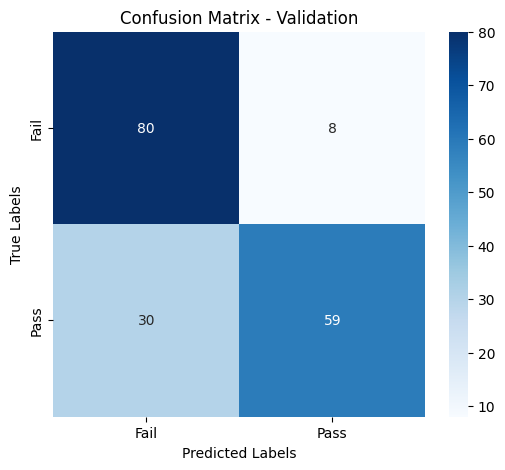

Validation Loss: 0.5007, Validation Accuracy: 0.7853, Validation F1: 0.7564, Validation ROC-AUC: 0.8623
Epoch 2/3
Train Loss: 0.5631, Train Accuracy: 0.7221

Validation Metrics:
Accuracy: 0.7797
F1 Score: 0.7451
ROC-AUC: 0.8398
Confusion Matrix:
[[81  7]
 [32 57]]


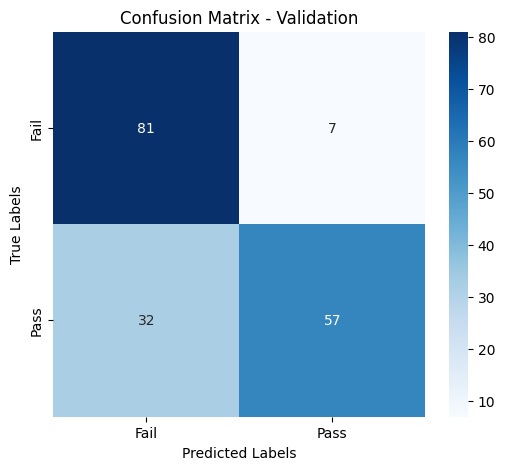

Validation Loss: 0.5087, Validation Accuracy: 0.7797, Validation F1: 0.7451, Validation ROC-AUC: 0.8398
Epoch 3/3
Train Loss: 0.4976, Train Accuracy: 0.7645


In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Environment variable for memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Tokenizer and Model Initialization
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2)
model.gradient_checkpointing_enable()
model.config.attention_window = [256] * len(model.config.attention_window)
model = torch.nn.DataParallel(model).to("cuda")

# Dataset with Optional Instruction Prompt
class ScriptDataset(Dataset):
    def __init__(self, scripts, labels, tokenizer, max_length=3072, use_prompt=False):
        self.scripts = scripts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_prompt = use_prompt
        self.prompt = (
            "Does the following manuscript pass the Bechdel test or not? "
            "A movie passes the Bechdel test if it fulfills three requirements: "
            "1) There are at least two named female characters, 2) They have a conversation, "
            "3) About something other than a man. Manuscript: "
        )

    def __len__(self):
        return len(self.scripts)

    def __getitem__(self, idx):
        text = self.prompt + self.scripts[idx] if self.use_prompt else self.scripts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# DataLoader Preparation
def prepare_dataloader(data, tokenizer, max_length, batch_size, use_prompt=False):
    dataset = ScriptDataset(
        scripts=data["script"].tolist(),
        labels=data["passed_bechdel"].tolist(),
        tokenizer=tokenizer,
        max_length=max_length,
        use_prompt=use_prompt
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load datasets
train_data = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_data = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_data = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Create DataLoaders
train_loader = prepare_dataloader(train_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
val_loader = prepare_dataloader(val_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
test_loader = prepare_dataloader(test_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)

# Optimizer, Loss, and Scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.001) #lowering learning rate and weight decay to address regularization issues
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()
gradient_accumulation_steps = 4

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title, dataset_name):
    """
    Plots a confusion matrix using Seaborn heatmap.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fail", "Pass"], yticklabels=["Fail", "Pass"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"{title} - {dataset_name}")
    plt.show()

# Training Loop
def train(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        with autocast("cuda"):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss = loss / gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        if step % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Evaluation Loop
def evaluate(model, dataloader, dataset_name):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            with autocast("cuda"):
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plot_confusion_matrix(conf_matrix, "Confusion Matrix", dataset_name)

    return total_loss / len(dataloader), accuracy, f1, roc_auc

# Main Training Loop
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train(model, train_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy, val_f1, val_roc_auc = evaluate(model, val_loader, "Validation")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}, Validation ROC-AUC: {val_roc_auc:.4f}")

# Evaluate on Test Data
test_loss, test_accuracy, test_f1, test_roc_auc = evaluate(model, test_loader, "Test")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")
